<a href="https://colab.research.google.com/github/345ishaan/algorithmic_trading/blob/main/Stock_Mode_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
#@title Install Dependencies
!pip install jugaad-data
!pip install pandas
!pip install yfinance
!pip install tslearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached beautifulsoup4-4.9.3-py3-none-any.whl (115 kB)
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.12.2
    Uninstalling beautifulsoup4-4.12.2:
      Successfully uninstalled beautifulsoup4-4.12.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yfinance 0.2.18 requires beautifulsoup4>=4.11.1, but you have beautifulsoup4 4.9.3 which is incompatible.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached beautifulsoup4-4.12.2-py3-none-any.whl (142 kB)
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.9.3
    Uninstalling beautifulsoup4-4.9.3:
      Successfully uninstalled beautifulsoup4-4.9.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jugaad-data 0.24 requires beautifulsoup4==4.9.3, but you have beautifulsoup4 4.12.2 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.2/358.2 kB 8.5 MB/s eta 0:00:00


In [32]:
from jugaad_data.nse import stock_df
import collections
from datetime import datetime
from datetime import timedelta
import numpy as np
import yfinance as yf
from calendar import monthrange
import calendar
import pandas as pd
import matplotlib.pyplot as plt
import requests
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


In [3]:
# Maps famous NSE indices to their data files on nseindia
NSE_INDEX_TO_CSV = {
    'NIFTY_50': 'https://raw.githubusercontent.com/345ishaan/algorithmic_trading/main/nifty_50.csv',
    'NIFTY_LARGEMIDCAP_250': 'https://raw.githubusercontent.com/345ishaan/algorithmic_trading/main/nifty_largemidcap_250.csv',
    'NIFTY_MIDSMALLCAP_400': 'https://raw.githubusercontent.com/345ishaan/algorithmic_trading/main/nifty_midsmallcap_400.csv',
}

In [4]:
def tickers_in_index(url_path):
  res = requests.get(url_path, allow_redirects=True)
  with open('data.csv','wb') as file:
    file.write(res.content)
  df = pd.read_csv('data.csv')
  return np.array(df['SYMBOL \n'][1:].values).tolist() 

In [5]:
#@title Params
start_year = 2012 #@param {type:"integer"}
end_year = 2020 #@param {type:"integer"}
index_name = 'NIFTY_LARGEMIDCAP_250' #@param

In [6]:
stock_tickers = tickers_in_index(NSE_INDEX_TO_CSV[index_name])
stock_tickers = list(map(lambda x : x +'.NS' , stock_tickers))

In [7]:
stock_data = yf.download(" ".join(stock_tickers), start="2012-01-01", end="2022-12-31")


[*********************100%***********************]  250 of 250 completed


In [8]:
stock_data['Open']['RELIANCE.NS'][:15]

Date
2012-01-02    345.128540
2012-01-03    352.780975
2012-01-04    360.284851
2012-01-05    354.143066
2012-01-06    345.252350
2012-01-09    353.870667
2012-01-10    352.657166
2012-01-11    365.485565
2012-01-12    370.240479
2012-01-13    367.516327
2012-01-16    361.547882
2012-01-17    354.638397
2012-01-18    377.422424
2012-01-19    390.795654
2012-01-20    391.290955
Name: RELIANCE.NS, dtype: float64

In [24]:
stock_data['Close']['RELIANCE.NS'][:15]

Date
2012-01-02    349.957764
2012-01-03    358.922760
2012-01-04    354.712677
2012-01-05    346.465851
2012-01-06    355.406097
2012-01-09    349.809143
2012-01-10    364.643555
2012-01-11    370.611969
2012-01-12    364.990265
2012-01-13    362.464203
2012-01-16    353.127716
2012-01-17    367.541077
2012-01-18    386.214081
2012-01-19    389.136383
2012-01-20    392.603516
Name: RELIANCE.NS, dtype: float64

In [25]:
stock_data['Adj Close']['RELIANCE.NS'][:15]

Date
2012-01-02    322.067139
2012-01-03    330.317657
2012-01-04    326.443054
2012-01-05    318.853516
2012-01-06    327.081268
2012-01-09    321.930389
2012-01-10    335.582458
2012-01-11    341.075195
2012-01-12    335.901611
2012-01-13    333.576813
2012-01-16    324.984406
2012-01-17    338.249084
2012-01-18    355.433929
2012-01-19    358.123322
2012-01-20    361.314148
Name: RELIANCE.NS, dtype: float64

In [20]:
#@title Find average month change over past xx years
PCT_DATA = {}
for stock in stock_tickers:
  PCT_DATA[stock] = {}
  month_ch = collections.defaultdict(list)
  month_valid = collections.defaultdict(list)
  for year in range(start_year, end_year + 1):
    # TODO: check if we query change without asking all info in a dataframe.
    for m in range(1, 12+1):
      num_days = monthrange(year, m)[1]
      week_day_end = datetime(year,m,num_days).weekday()
      valid_start = 1
      valid_open = None
      valid_end = num_days
      valid_close = None
      while valid_open is None:
        try:
          str_start = f'0{valid_start}' if valid_start < 10 else f'{valid_start}'
          str_m = f'0{m}' if m < 10 else f'{m}'
          month_start = f'{year}-{str_m}-{str_start}'
          valid_open = stock_data['Open'][stock][month_start]
        except Exception as e:
          valid_start += 1
          valid_start %= num_days
      end_m = m
      while valid_close is None:
        try:
          str_end = f'0{valid_end}' if valid_end < 10 else f'{valid_end}'
          str_m = f'0{end_m}' if end_m < 10 else f'{end_m}'
          month_end = f'{year}-{str_m}-{str_end}'
          valid_close = stock_data['Close'][stock][month_end]
        except Exception as e:
          valid_end = (valid_end + 1)% num_days
          end_m = m+1 if m + 1 < 12 else 1

      delta_change = valid_close - valid_open
      pct_change = (delta_change / valid_open)*100
      month_ch[m].append(pct_change)
      month_valid[m].append(1)
  PCT_DATA[stock]['month_ch'] = month_ch
  PCT_DATA[stock]['month_valid'] = month_valid

In [21]:
print(PCT_DATA['TORNTPHARM.NS']['month_ch'][1])

[1.274530049993312, -3.5606026977875342, 14.214604036918738, 0.8533311631944445, -4.3838618350381005, -1.3058552878089187, -3.988722733328929, 1.9535356153549601, 4.108035482718026, -9.590060796061, -18.51609116449977]


Text(0, 0.5, '%change')

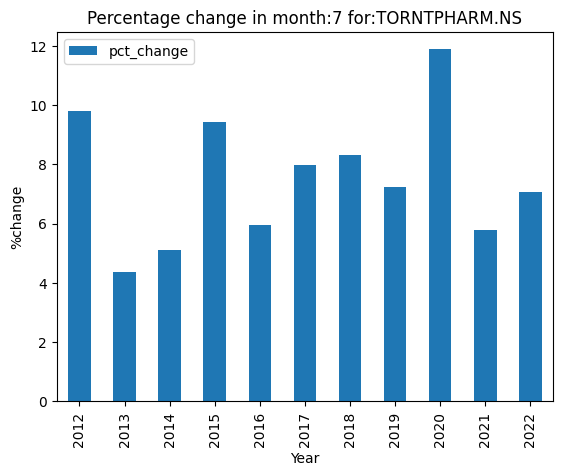

In [22]:
#@title Plot per month bar plot given stock symbol

plot_stock_symbol = 'TORNTPHARM.NS' #@param {type:"string"}
plot_month = 7 #@param
plotdata = pd.DataFrame([{'pct_change': PCT_DATA[plot_stock_symbol]['month_ch'][plot_month][x], } for x,_ in enumerate(range(start_year, end_year + 1))],
                        index=[year for year in range(start_year, end_year + 1)])
plotdata.plot(kind="bar")
plt.title(f"Percentage change in month:{plot_month} for:{plot_stock_symbol}")
plt.xlabel("Year")
plt.ylabel("%change")

In [23]:
#@title Find stock months where PCT_Change > threshold more than x% of year range.

YEAR_X = 1.0 #@param
PCT_THRESHOLD = 5 #@param
MONTH_RANGE = range(1,13)
FILTERED_STOCKS = []
for stock in PCT_DATA:
  max_num = 0
  max_month = None
  for month in MONTH_RANGE:
    month_ch = np.array(PCT_DATA[stock]['month_ch'][month])
    total_months = np.sum(np.array(month_ch > PCT_THRESHOLD))
    if max_num < total_months:
      max_month = month
      max_num = total_months
  # max_month / max_num
  # Feb: 10 March : 8 Jun: 6
  # max_month = Feb
  # max_num = 10
  # max_num >= percentage of year_range:
  if max_num >= YEAR_X*(end_year-start_year):
    FILTERED_STOCKS.append({'ticker': stock, 'best_month': max_month, 'count': max_num})
print(FILTERED_STOCKS)
  

[{'ticker': 'TORNTPHARM.NS', 'best_month': 7, 'count': 10}]


# Momentum Analysis
For a given stock, if we see a particular month where it's value always
increases in a particular month, we want to see how much momentum is carry forwarded from past months and whether momentum wave correlation is consistent.

Momentum can be bucketed into:


*   Short-cycle (1 month / 4 weeks)
*   Mid-cycle (4 months / 16 weeks)

*   Long-cycle (9 months / 36 weeks)





In [46]:
def get_past_week_momentum(stock: str, num_before_weeks: int, before_month: int, start_year: int, end_year: int, normalize_time_series: bool):
  '''
  Get data for the given stock for num_weeks before the month provided from
  start to end year.
  '''
  momentum = {}
  num_before_days = 5*num_before_weeks
  plt.figure(figsize=(16, 8), dpi=150)
  for year in range(start_year, end_year + 1):
    # find opening and closing before seek_before_date for num_weeks.
    seek_before_date = datetime(year,before_month, 1)
    count_before = 0
    momentum[year] = {
        'metric': [],
        'date': [],
    }
    while count_before < num_before_days:
      date = seek_before_date - timedelta(1)
      date_str = date.__str__()
      seek_before_date = date
      try:
        open = stock_data['Open'][stock][date_str]
        close = stock_data['Close'][stock][date_str]
        adj_close = stock_data['Adj Close'][stock][date_str]
        delta = (close-open) / open
        momentum[year]['metric'].append(adj_close)
        momentum[year]['date'].append(date_str)
        count_before += 1
      except Exception as e:
        continue

    momentum[year]['metric'].reverse()
    if normalize_time_series:
      metric_np = np.array(momentum[year]['metric'])
      mean_t = np.nanmean(metric_np, axis=0, keepdims=True)
      std_t = np.nanstd(metric_np, axis=0, keepdims=True)
      std_t[std_t == 0.] = 1.
      metric_np = (metric_np - mean_t) / std_t
      momentum[year]['metric'] = metric_np.tolist()
    momentum[year]['date'].reverse()
    label_str = f'Year = {year}'
    pd.DataFrame(data=momentum[year])['metric'].plot(label=label_str)
  plt.title('Momentume time series plot')
  plt.ylabel('per-day % delta')
  plt.xlabel('days')
  plt.legend()
  return momentum


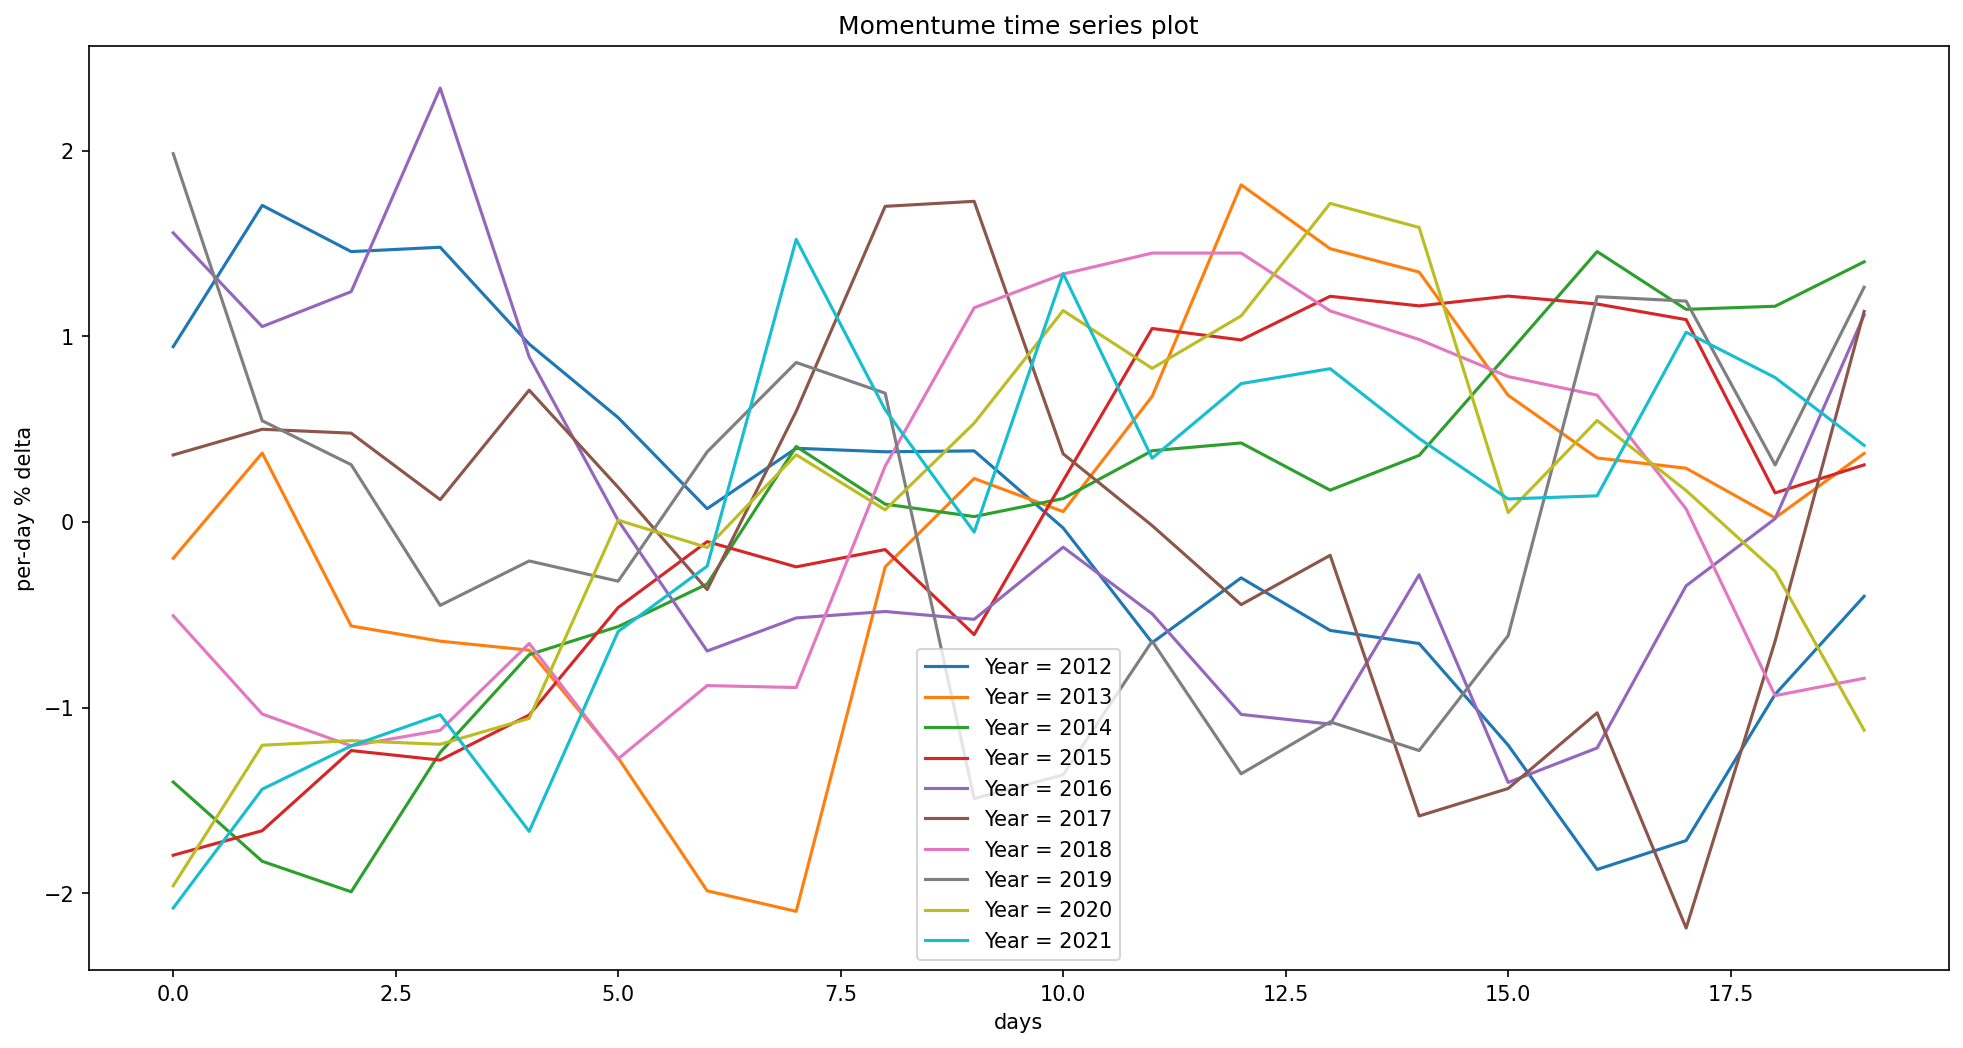

In [157]:
short_momentum = get_past_week_momentum(stock='TORNTPHARM.NS', num_before_weeks=4, before_month=7,start_year=2012, end_year=2021, normalize_time_series=True)

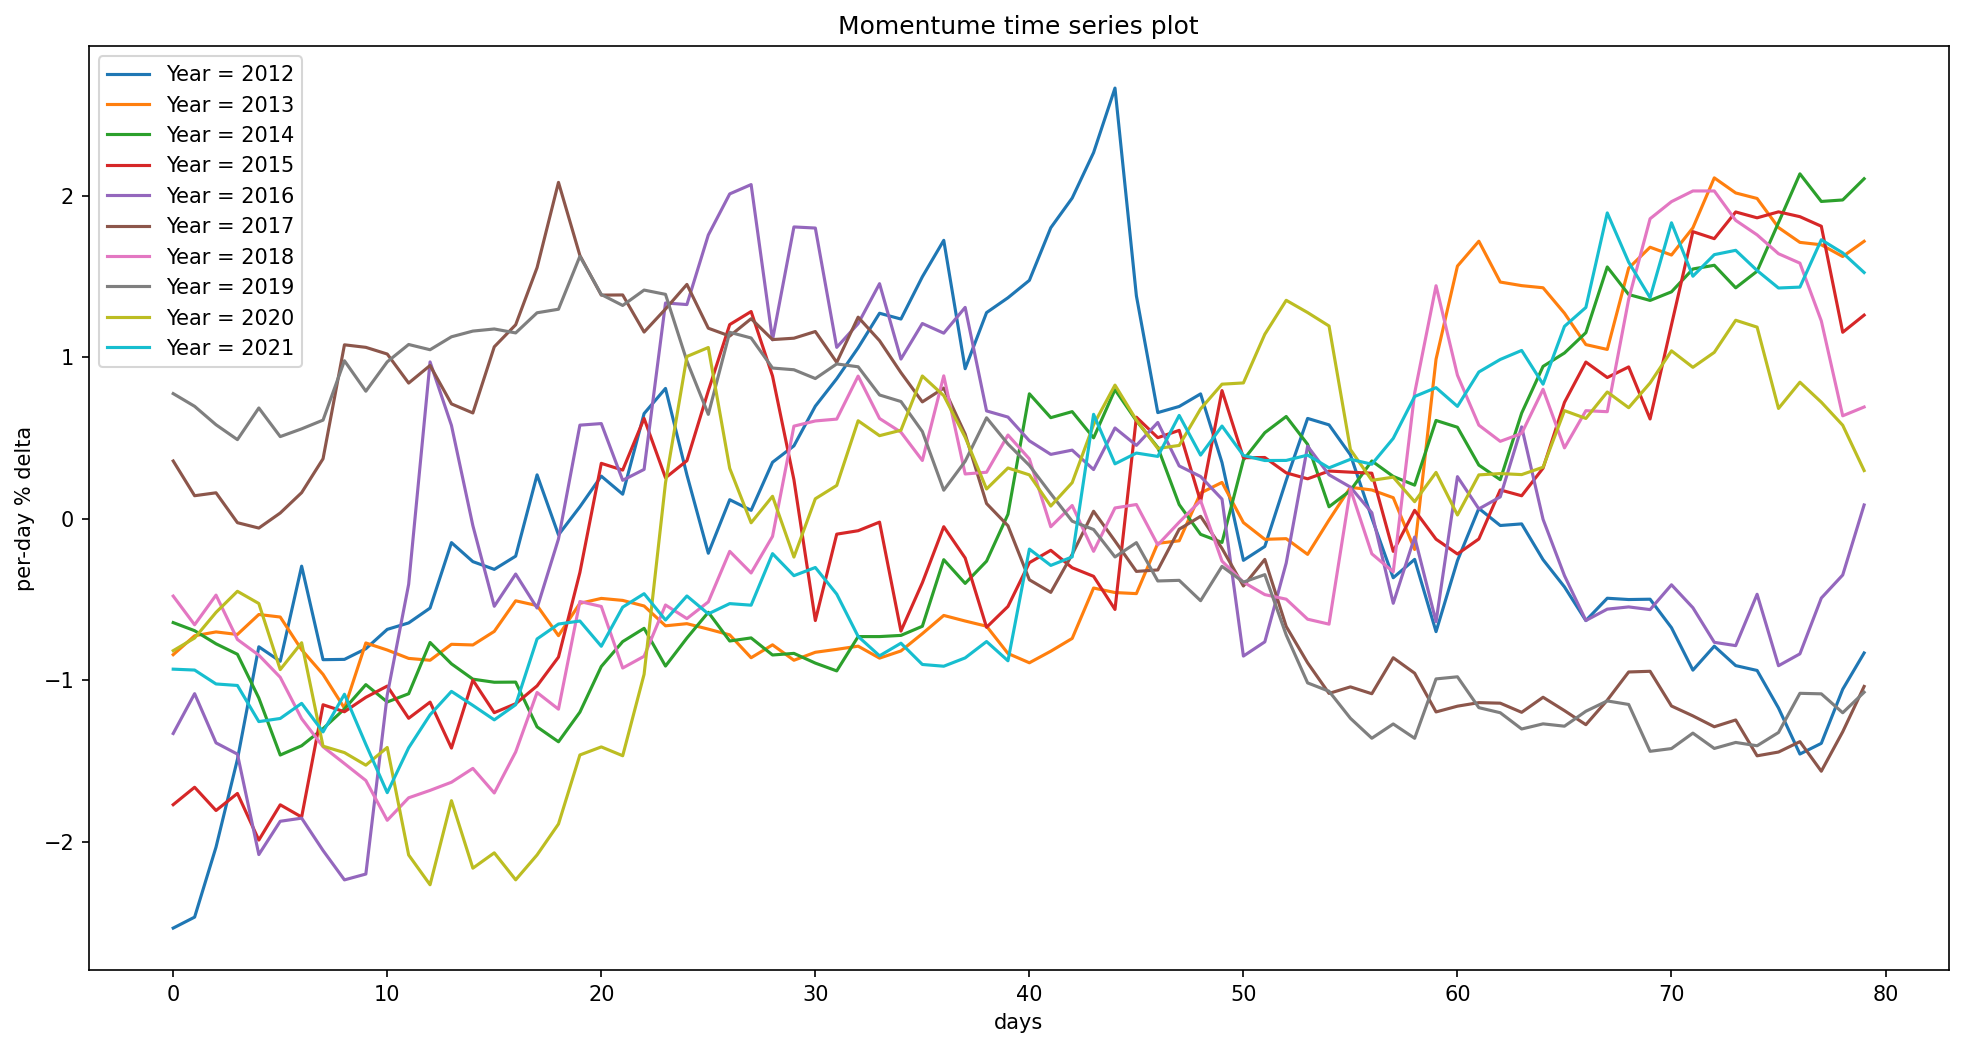

In [158]:
mid_momentum = get_past_week_momentum(stock='TORNTPHARM.NS', num_before_weeks=16, before_month=7,start_year=2012, end_year=2021, normalize_time_series=True)

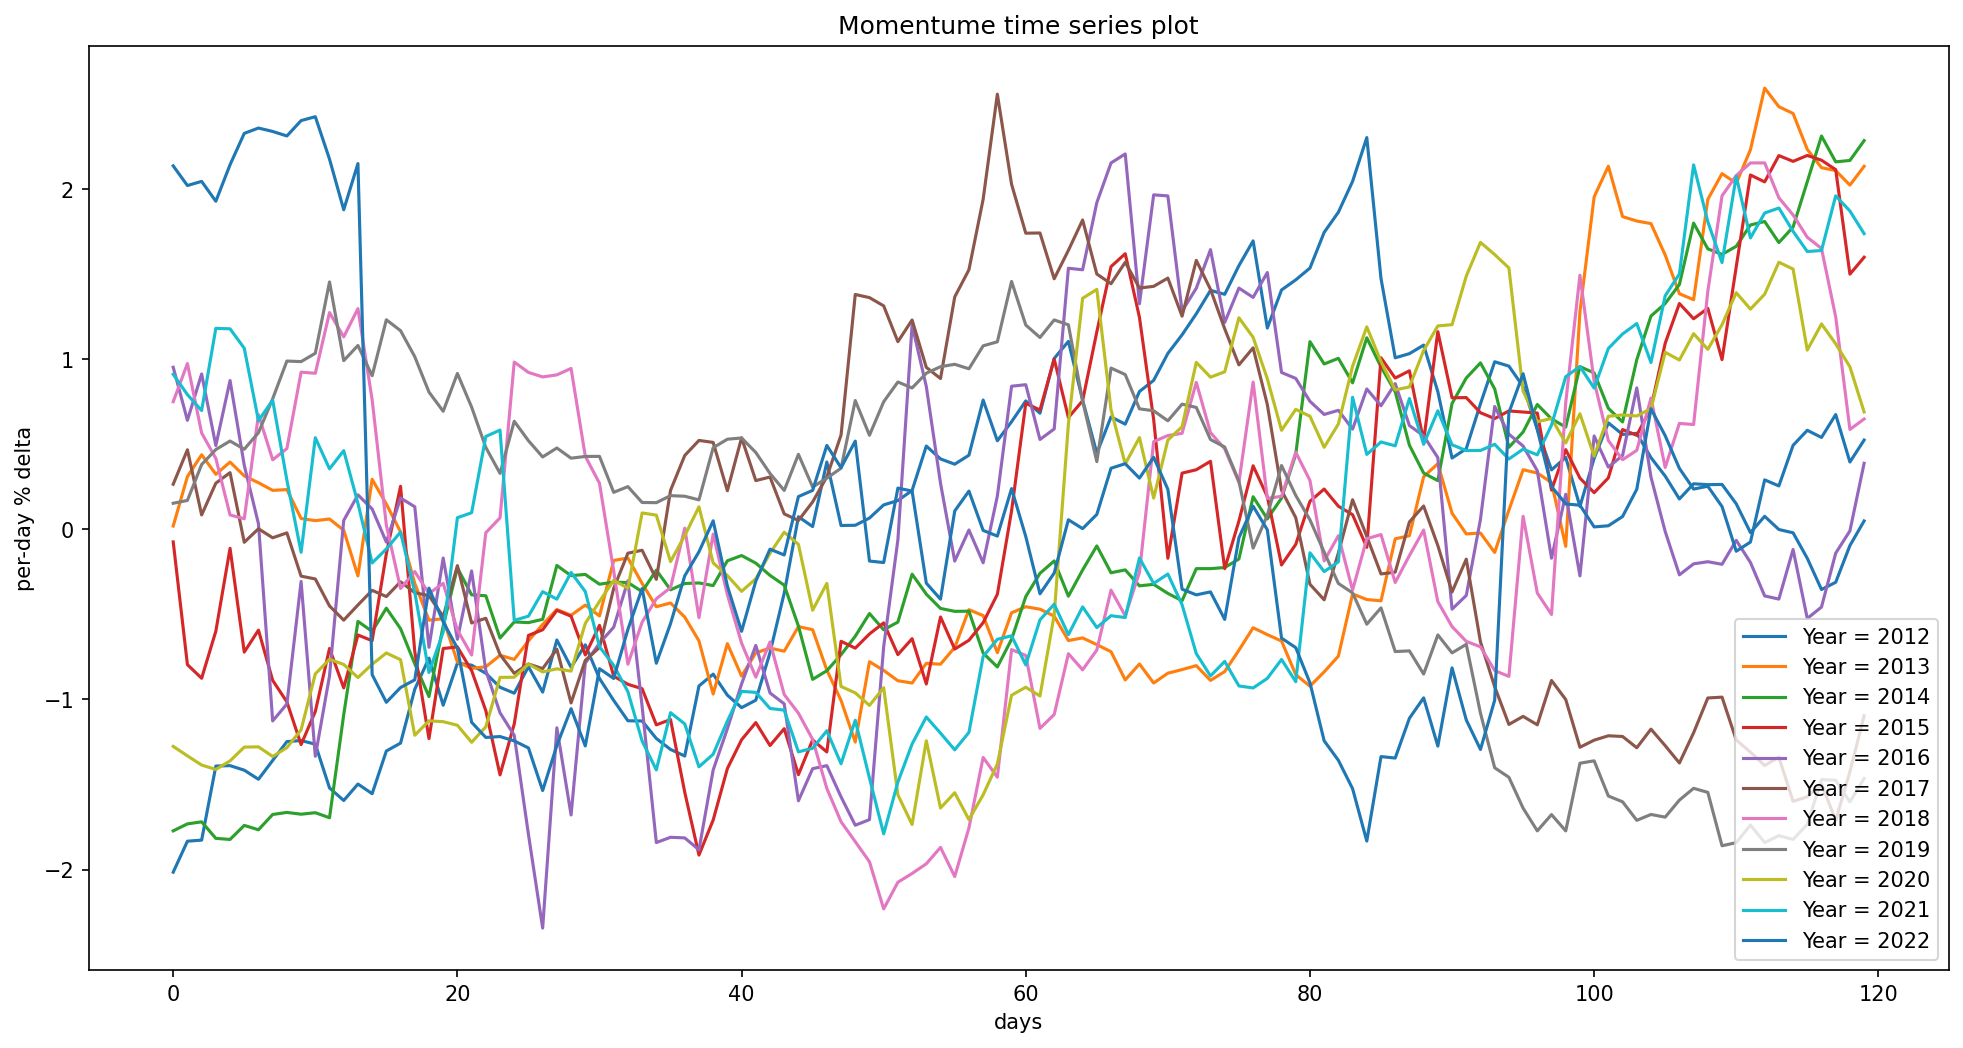

In [50]:
large_momentum = get_past_week_momentum(stock='TORNTPHARM.NS', num_before_weeks=24, before_month=7,start_year=2012, end_year=2022, normalize_time_series=True)

In [9]:
#@title Time Series Clustering

In [121]:
def cluster_time_series(n_clusters, X_train, y_train, plot):
  model = TimeSeriesKMeans(n_clusters=4,
            n_init=2,
            metric="dtw",
            verbose=False,
            max_iter_barycenter=10,tol=1e-4,
            random_state=77,n_jobs=-1)
  labels= model.fit_predict(X_train)
  if plot:
    plt.figure(figsize=(16, 8), dpi=150)
    col_map = {}
    clusters = pd.DataFrame()
    for i in range(n_clusters):
      X_ = X_train[labels == i]
      if len(X_):
        years = '_'.join(y_train[labels==i].squeeze().tolist())
        cluster_name = f'Cluster_{i}_{years}'
        clusters[cluster_name] = X_.mean(axis=0).squeeze()
    clusters.plot(title='Average across cluster')
    plt.legend()
  return model


In [60]:
short_momentum_np = np.array(list(map(lambda x : short_momentum[x]['metric'], short_momentum)))
mid_momentum_np = np.array(list(map(lambda x : mid_momentum[x]['metric'], mid_momentum)))
large_momentum_np = np.array(list(map(lambda x : large_momentum[x]['metric'], large_momentum)))

<Figure size 2400x1200 with 0 Axes>

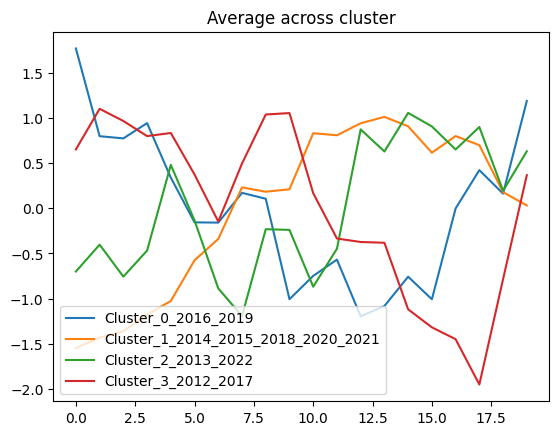

In [118]:
short_cluster = cluster_time_series(n_clusters=4, X_train=np.expand_dims(short_momentum_np, axis=2), 
                                    y_train=np.expand_dims(np.array(list(map(lambda x : str(x), range(2012, 2023)))), axis=1),
                                    plot=True)

<Figure size 2400x1200 with 0 Axes>

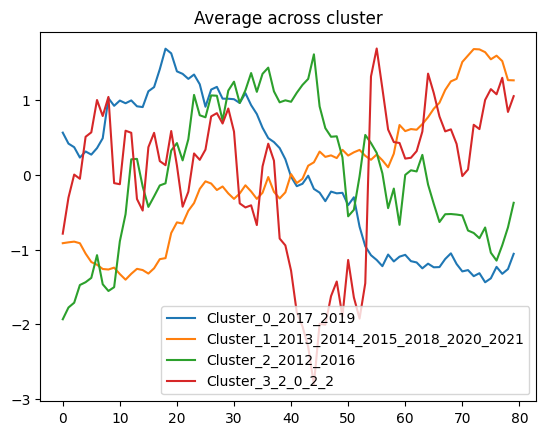

In [119]:
mid_cluster = cluster_time_series(n_clusters=4, X_train=np.expand_dims(mid_momentum_np, axis=2), 
                                    y_train=np.expand_dims(np.array(list(map(lambda x : str(x), range(2012, 2023)))), axis=1),
                                    plot=True)

In [161]:
large_momentum_np[:-1,:].shape

(10, 120)

<Figure size 2400x1200 with 0 Axes>

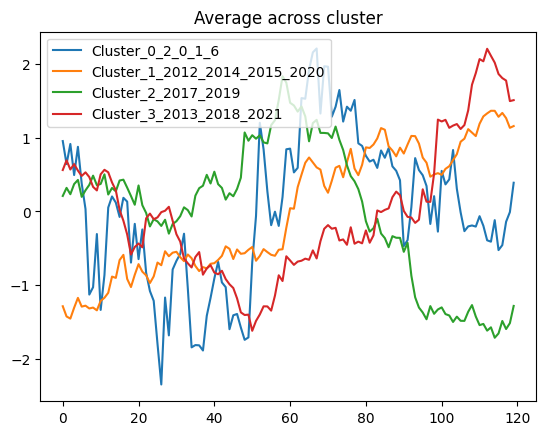

In [162]:
large_cluster = cluster_time_series(n_clusters=4, X_train=np.expand_dims(large_momentum_np[:-1, :], axis=2), 
                                    y_train=np.expand_dims(np.array(list(map(lambda x : str(x), range(2012, 2022)))), axis=1),
                                    plot=True)

In [170]:
def get_cluster_distance(model, X_train, Y_train, test_year, x_test):
  label = model.predict(x_test)
  label_train = X_train[model.labels_ == label[0]]
  cluster_count = len(label_train)
  delta_error = np.mean(np.abs(x_test - label_train), axis=1)
  weight = 1. / (test_year - Y_train[model.labels_ == label[0]] + 1e-14)
  return np.sum(delta_error * weight) / np.sum(weight), cluster_count



In [172]:
get_cluster_distance(large_cluster,  X_train=np.expand_dims(large_momentum_np[:-1,:], axis=2), 
                        Y_train=np.expand_dims(np.array(list(map(lambda x : x, range(2012, 2022)))), axis=1),
                        test_year=2020, x_test=np.array(large_momentum[2020]['metric']).reshape(1, -1, 1))

(3.0485570100291257e-15, 4)